In [1]:
import sklearn
import pandas as pd
import numpy as np
import nltk
import sklearn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import train_test_split
import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import pickle
from wordcloud import WordCloud

In [2]:
full_reviewed_data_drop = pd.read_csv('../../input_data/full_datasets/fully_hand_labelled_texts.csv')

In [3]:
indices = pd.read_csv('medrobertanl-haga_smoking_predictions.csv', delimiter=';')

In [4]:
test_set = full_reviewed_data_drop.loc[indices['index']]

In [5]:
train_set = full_reviewed_data_drop.loc[~full_reviewed_data_drop.index.isin(test_set.index)]

In [6]:
train_set['Roken'].value_counts()

Niets gevonden          2532
Voormalige gebruiker     731
Geen gebruiker           356
Huidige gebruiker        141
Name: Roken, dtype: int64

In [7]:
test_set['Roken'].value_counts()

Niets gevonden          611
Voormalige gebruiker    208
Geen gebruiker           83
Huidige gebruiker        38
Name: Roken, dtype: int64

In [8]:
train_set['Alcohol'].value_counts()

Niets gevonden          2673
Geen gebruiker           597
Huidige gebruiker        474
Voormalige gebruiker      16
Name: Alcohol, dtype: int64

In [9]:
test_set['Alcohol'].value_counts()

Niets gevonden          648
Geen gebruiker          147
Huidige gebruiker       142
Voormalige gebruiker      3
Name: Alcohol, dtype: int64

In [10]:
train_set['Drugs'].value_counts()

Niets gevonden          2702
Geen gebruiker           998
Huidige gebruiker         50
Voormalige gebruiker      10
Name: Drugs, dtype: int64

In [11]:
test_set['Drugs'].value_counts()

Niets gevonden          655
Geen gebruiker          274
Huidige gebruiker        10
Voormalige gebruiker      1
Name: Drugs, dtype: int64

In [35]:
test_set.text = test_set.text.str.replace("_x000D_\n", "\t")


In [36]:
Corpus = test_set.copy()

In [37]:
roken_corpus = Corpus[['text', 'Roken']]

In [38]:
roken_corpus['text'] = roken_corpus.text.str.lower()

<ipython-input-38-d163318cb242>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roken_corpus['text'] = roken_corpus.text.str.lower()


In [39]:
roken_corpus['text'] = roken_corpus.text.str.replace("\t", "")

<ipython-input-39-518e6ea63137>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roken_corpus['text'] = roken_corpus.text.str.replace("\t", "")


In [40]:
def sm_previous_user_check(text):
    return "rookt niet meer" in text or "gestopt met roken" in text

def sm_current_user_check(text):
    if "rookt +" in text or "rookt+" in text:
        return True
    if "roker +" in text or "roker+" in text:
        return True
    if "roken +" in text or "roken+" in text:
        return True
    if "rookster +" in text or "rookster+" in text:
        return True
    if "rookt: ja" in text:
        return True
    if "roker: ja" in text or "rookster: ja" in text:
        return True
    if "rookt soms" in text or "rookt: soms" in text:
        return True
    if "roken ++" in text:
        return True
    return False

def sm_non_user_check(text):
    if "rookt -" in text or "rookt-" in text:
        return True
    if "roker -" in text or "roker-" in text:
        return True
    if "roken -" in text or "roken-" in text:
        return True
    if "rookster -" in text or "rookster-" in text:
        return True
    if "rookt: nee" in text:
        return True
    if "roker: nee" in text or "rookster: nee" in text:
        return True
    if "rookt nooit" in text or "rookt: nooit" in text:
        return True
    if "roken --" in text:
        return True
    return False
    
def apply_string_matching(row):
    text = row['text']
    if sm_previous_user_check(text):
        return "Voormalige gebruiker"
    if sm_current_user_check(text):
        return "Huidige gebruiker"
    if sm_non_user_check(text):
        return "Geen gebruiker"
    return "Niets gevonden"

roken_corpus['sm_label'] = roken_corpus.apply(lambda row: apply_string_matching(row), axis=1)

<ipython-input-40-b46eb7cdeb31>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roken_corpus['sm_label'] = roken_corpus.apply(lambda row: apply_string_matching(row), axis=1)


In [41]:
roken_corpus

,text,Roken,sm_label
2,conclusie: normale nacontrole. kijkt goed teru...,Niets gevonden,Niets gevonden
17,conclusie: samenvatting abcde: icc bij trauma ...,Niets gevonden,Niets gevonden
37,"beloop: staat gepland voor tc, echter nummer n...",Niets gevonden,Niets gevonden
40,beloop: lab belt: materiaal van 24-uurs urine ...,Niets gevonden,Niets gevonden
48,beloop: beloop: reguliere controle na acdf c4-...,Huidige gebruiker,Niets gevonden
...,...,...,...
4678,samenvatting: voorgeschiedenis: in verleden pr...,Geen gebruiker,Niets gevonden
4682,"anamnese: nog steeds hielspoor links, heeft al...",Geen gebruiker,Geen gebruiker
4688,reden van komst / verwijzing: reden verwijzing...,Geen gebruiker,Geen gebruiker
4691,anamnese: verkort consult: aandachtspunten ui...,Huidige gebruiker,Geen gebruiker


0.9436170212765957


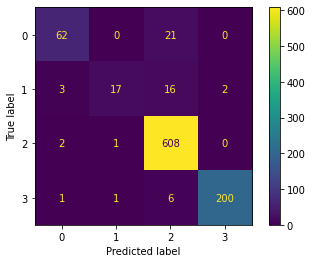

                      precision    recall  f1-score   support

      Geen gebruiker       0.91      0.75      0.82        83
   Huidige gebruiker       0.89      0.45      0.60        38
      Niets gevonden       0.93      1.00      0.96       611
Voormalige gebruiker       0.99      0.96      0.98       208

            accuracy                           0.94       940
           macro avg       0.93      0.79      0.84       940
        weighted avg       0.94      0.94      0.94       940



In [42]:
print(np.mean(roken_corpus['sm_label'] == roken_corpus['Roken']))
cm = confusion_matrix(roken_corpus['Roken'], roken_corpus['sm_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(metrics.classification_report(roken_corpus['Roken'], roken_corpus['sm_label']))

In [44]:
roken_corpus.to_csv('smoking_string_matching_predictions.csv')

In [45]:
alcohol_corpus = Corpus[['text', 'Alcohol']]

In [46]:
alcohol_corpus

,text,Alcohol
2,Conclusie: \tNormale nacontrole. Kijkt goed te...,Niets gevonden
17,Conclusie: \tSamenvatting ABCDE: ICC bij traum...,Niets gevonden
37,"Beloop: \tStaat gepland voor TC, echter nummer...",Niets gevonden
40,Beloop: \tLab belt: materiaal van 24-uurs urin...,Niets gevonden
48,Beloop: \tBeloop: Reguliere controle na ACDF C...,Niets gevonden
...,...,...
4678,Samenvatting: \tVoorgeschiedenis: in verleden ...,Niets gevonden
4682,"Anamnese: \tNog steeds hielspoor links, heeft ...",Geen gebruiker
4688,Reden van komst / Verwijzing: \tReden verwijzi...,Huidige gebruiker
4691,Anamnese: \t Verkort consult: Aandachtspunten ...,Geen gebruiker


In [47]:
alcohol_corpus['text'] = alcohol_corpus.text.str.lower()

<ipython-input-47-4bf5a4df4d02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alcohol_corpus['text'] = alcohol_corpus.text.str.lower()


In [48]:
alcohol_corpus['text'] = alcohol_corpus.text.str.replace("\t", "")

<ipython-input-48-9593ce6140e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alcohol_corpus['text'] = alcohol_corpus.text.str.replace("\t", "")


In [49]:
alcohol_corpus['Alcohol'] = alcohol_corpus.Alcohol.str.replace("Voormalige gebruiker", "Geen gebruiker")

<ipython-input-49-4d85a78e2b63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alcohol_corpus['Alcohol'] = alcohol_corpus.Alcohol.str.replace("Voormalige gebruiker", "Geen gebruiker")


In [50]:
def al_current_user_check(text):
    if "alcohol +" in text or "alcohol+" in text:
        return True
    if "alcohol: ja" in text:
        return True
    if "drinkt alcohol" in text:
        return True
    if "alcohol af en toe" in text:
        return True
    if "alcohol per week" in text or "alcohol week" in text:
        return True
    if "invloed van alcohol" in text:
        return True
    return False

def al_non_user_check(text):
    if "alcohol -" in text or "alcohol-" in text:
        return True
    if "alcohol: nee" in text:
        return True
    if "drinkt geen alcohol" in text:
        return True
    if "geen alcohol" in text:
        return True
    if "alcohol: geheel niet" in text:
        return True
    if "alcohol: geen" in text:
        return True
    return False
    
def apply_string_matching(row):
    text = row['text']
    if al_current_user_check(text):
        return "Huidige gebruiker"
    if al_non_user_check(text):
        return "Geen gebruiker"
    return "Niets gevonden"

alcohol_corpus['al_label'] = alcohol_corpus.apply(lambda row: apply_string_matching(row), axis=1)

<ipython-input-50-50f91365e16e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alcohol_corpus['al_label'] = alcohol_corpus.apply(lambda row: apply_string_matching(row), axis=1)


In [51]:
alcohol_corpus

,text,Alcohol,al_label
2,conclusie: normale nacontrole. kijkt goed teru...,Niets gevonden,Niets gevonden
17,conclusie: samenvatting abcde: icc bij trauma ...,Niets gevonden,Niets gevonden
37,"beloop: staat gepland voor tc, echter nummer n...",Niets gevonden,Niets gevonden
40,beloop: lab belt: materiaal van 24-uurs urine ...,Niets gevonden,Niets gevonden
48,beloop: beloop: reguliere controle na acdf c4-...,Niets gevonden,Niets gevonden
...,...,...,...
4678,samenvatting: voorgeschiedenis: in verleden pr...,Niets gevonden,Niets gevonden
4682,"anamnese: nog steeds hielspoor links, heeft al...",Geen gebruiker,Geen gebruiker
4688,reden van komst / verwijzing: reden verwijzing...,Huidige gebruiker,Huidige gebruiker
4691,anamnese: verkort consult: aandachtspunten ui...,Geen gebruiker,Geen gebruiker


0.9882978723404255


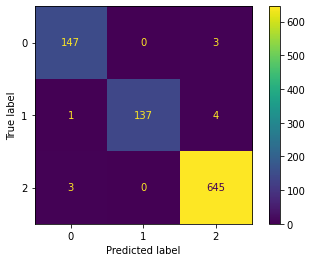

                   precision    recall  f1-score   support

   Geen gebruiker       0.97      0.98      0.98       150
Huidige gebruiker       1.00      0.96      0.98       142
   Niets gevonden       0.99      1.00      0.99       648

         accuracy                           0.99       940
        macro avg       0.99      0.98      0.98       940
     weighted avg       0.99      0.99      0.99       940



In [52]:
print(np.mean(alcohol_corpus['al_label'] == alcohol_corpus['Alcohol']))
cm = confusion_matrix(alcohol_corpus['Alcohol'], alcohol_corpus['al_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(metrics.classification_report(alcohol_corpus['Alcohol'], alcohol_corpus['al_label']))

In [53]:
drugs_corpus = Corpus[['text', 'Drugs']]

In [54]:
drugs_corpus['text'] = drugs_corpus.text.str.lower()

<ipython-input-54-7fb2b069b0af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_corpus['text'] = drugs_corpus.text.str.lower()


In [55]:
drugs_corpus['text'] = drugs_corpus.text.str.replace("\t", "")

<ipython-input-55-721798d2705e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_corpus['text'] = drugs_corpus.text.str.replace("\t", "")


In [56]:
drugs_corpus['Drugs'] = drugs_corpus.Drugs.str.replace("Voormalige gebruiker", "Geen gebruiker")

<ipython-input-56-48d6b120817f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_corpus['Drugs'] = drugs_corpus.Drugs.str.replace("Voormalige gebruiker", "Geen gebruiker")


In [57]:
def dr_current_user_check(text):
    if "drugs +" in text or "drugs+" in text:
        return True
    if "drugs: ja" in text:
        return True
    if "gebruikt drugs" in text:
        return True
    return False

def dr_non_user_check(text):
    if "drugs -" in text or "drugs-" in text:
        return True
    if "drugs: nee" in text:
        return True
    if "drugs niet" in text:
        return True
    if "geen drugs" in text:
        return True
    return False
    
def apply_string_matching(row):
    text = row['text']
    if dr_current_user_check(text):
        return "Huidige gebruiker"
    if dr_non_user_check(text):
        return "Geen gebruiker"
    return "Niets gevonden"

drugs_corpus['dr_label'] = drugs_corpus.apply(lambda row: apply_string_matching(row), axis=1)

<ipython-input-57-3d8ac5f5dbc0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_corpus['dr_label'] = drugs_corpus.apply(lambda row: apply_string_matching(row), axis=1)


0.9893617021276596


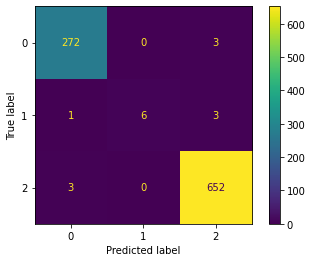

                   precision    recall  f1-score   support

   Geen gebruiker       0.99      0.99      0.99       275
Huidige gebruiker       1.00      0.60      0.75        10
   Niets gevonden       0.99      1.00      0.99       655

         accuracy                           0.99       940
        macro avg       0.99      0.86      0.91       940
     weighted avg       0.99      0.99      0.99       940



In [58]:
print(np.mean(drugs_corpus['dr_label'] == drugs_corpus['Drugs']))
cm = confusion_matrix(drugs_corpus['Drugs'], drugs_corpus['dr_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(metrics.classification_report(drugs_corpus['Drugs'], drugs_corpus['dr_label']))